# Maximum Likelihood Estimation of the Q Parameter in the Marcenko-Pastur Law

In [1]:
import os
import numpy as np
from scipy.optimize import minimize
import datetime
import matplotlib.pyplot as plt

# import custom functions
from corrmat_functions import *

## Load correlation matrices
and keep track of the timestamps, so that mapping Q to the matrices is trivial. timestamps are the keys of the dictionary.

In [2]:
# load all correlation matrices
corrmats = load_all_corrmats()

## remove colums (and rows) of nan values

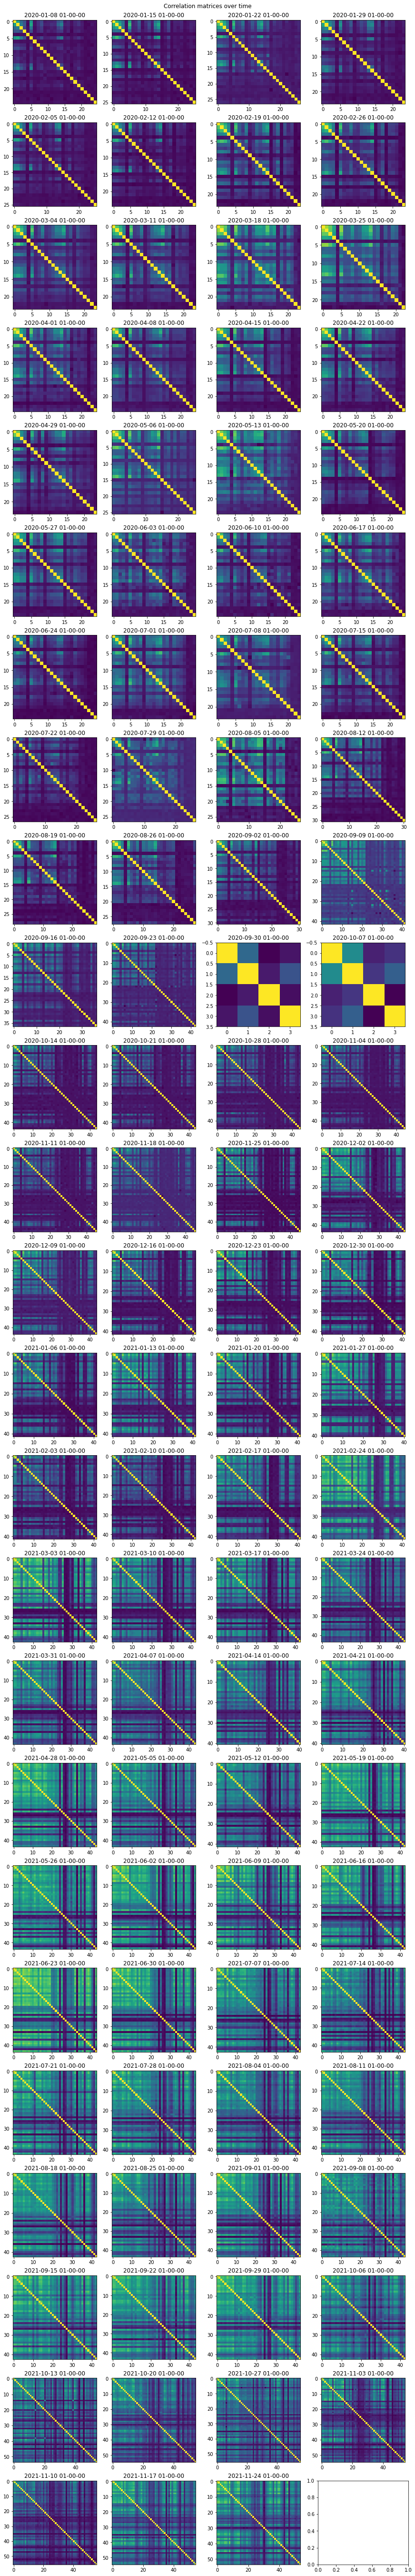

In [3]:
# load full list of tickers
tickers = load_corrmat_tickers()

# nn stands for "not null" or "not nan"
corrmats_nn = {}
tickers_nn = {}
for i in corrmats.keys():
    corrmats_nn[i], tickers_nn[i] = notnull_corrmat_and_tickers(corrmats[i], tickers)

print_corrmats(corrmats_nn)

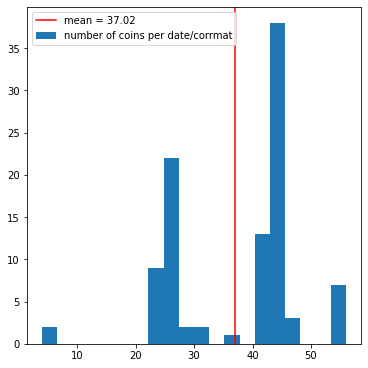

In [4]:
n_tickers_per_date = [len(i) for i in tickers_nn.values()]
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
ax.hist(n_tickers_per_date, bins=20, label="number of coins per date/corrmat")
ax.axvline(np.mean(n_tickers_per_date), label=f"mean = {np.round(np.mean(n_tickers_per_date),2)}", color='red')
ax.legend()

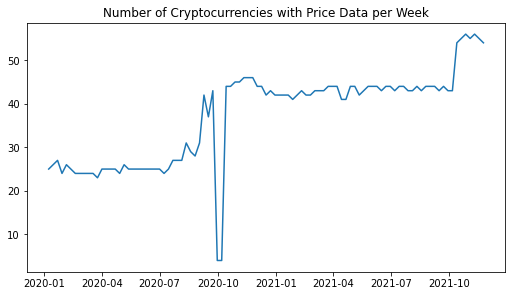

In [5]:
# plot number of cryptocurrencies over time
nr_crypto = []
dates = sorted(corrmats_nn.keys())
for i in dates:
    nr_crypto.append(corrmats_nn[i].shape[0])

dates = [datetime.datetime.strptime(i, "%Y-%m-%d %H-%M-%S").date() for i in dates]
fig, ax = plt.subplots(1,1, figsize=(7,4), constrained_layout=True)
ax.plot(dates, nr_crypto)
# ax.set_xticklabels(labels=dates, rotation=90)
ax.set_title("Number of Cryptocurrencies with Price Data per Week")
fig.savefig("figures/nr_cryptos.png")

## Maximum likelihood estimation

In [6]:
def lambda_min_max(Q, sigma):
    a = 2*np.sqrt(1/Q)
    lam_min, lam_max =  np.square(sigma) * (1 + 1/Q + np.array([-a, a]))
    return lam_min, lam_max

def MP(lam, Q, lam_min, lam_max, sigma=1):
    """
    Compute marcenko-pastur fit for fixed Q evaluated at some lambda.
    return likelihood
    """
    rho = (Q / (2*np.pi*np.square(sigma))) * (np.sqrt((lam_max-lam)*(lam-lam_min)) / lam)
    return rho

def negative_log_likelihood_MP(Q, lambda_array):
    """compute negative log likelihood of function MP."""
    sigma = 1

    # compute lambda_min and lambda_max
    lam_min, lam_max = lambda_min_max(Q, sigma)

    # take only lambdas in [lam_min, lam_max]
    lambda_array = lambda_array[(lambda_array >= lam_min) & (lambda_array <= lam_max)]
    # compute likelihood at every value of lambda in the data
    ll = np.zeros(len(lambda_array))
    for i,lam in enumerate(lambda_array):
        ll[i] = MP(lam, Q, lam_min, lam_max, sigma=sigma)

    ll = -np.sum(np.log(ll))
    return ll

In [7]:
# load T (length of time series)
_, T = np.genfromtxt("data/data_slice_dim_(N,T).txt")
T = int(T)
print(T)

10080


## minimize negative log likelihood

In [8]:
# for every matrix estimate Q
Qs_mle = {}
Qs_theory = {}
for i in sorted(corrmats_nn.keys()):
    # compute initial guess for Q as T/N
    N = len(tickers_nn[i])
    Qs_theory[i] = np.max([T/N, 1])

    # compute eigenvalues
    lambdas, _ = np.linalg.eig(corrmats_nn[i])

    # constraints
    bnds = [(1, None)]  # Q >= 1
    mle = minimize(negative_log_likelihood_MP, Qs_theory[i], args=(lambdas,), bounds=bnds, method="SLSQP")
    if not mle.success:
        print(f"{i} did not converge! Use initial guess T/N instead.")
        Qs_mle[i] = Qs_theory[i]
        print(mle)

    Qs_mle[i] = float(mle.x)

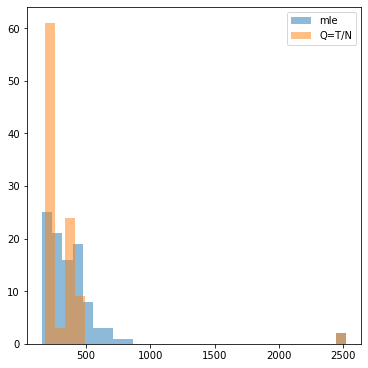

In [9]:
# print distribution of Q values
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
vals_mle = [i for i in Qs_mle.values()]
vals_theory = [i for i in Qs_theory.values()]
ax.hist(vals_mle, alpha=.5, bins=30, label="mle")
ax.hist(vals_theory, alpha=.5, bins=30, label="Q=T/N")
ax.legend()

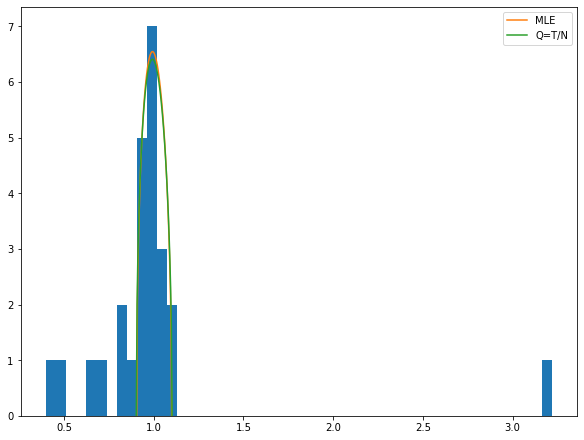

In [10]:
# test on some eigenvalues
timestamp = "2020-01-08 01-00-00"

c = corrmats_nn[timestamp]
q = Qs_mle[timestamp]
eigvals, _ = np.linalg.eig(c)

# compute pdf of MP (using Q_mle)
lam_min, lam_max = lambda_min_max(q, 1)
grid_mle = np.linspace(lam_min, lam_max, num = 50)
rho_mle = [MP(l, q, lam_min, lam_max, 1) for l in grid_mle]

# compute pdf of MP (using Q=T/N)
N = len(tickers_nn[timestamp])
q = Qs_theory[timestamp]
lam_min, lam_max = lambda_min_max(q, 1)
grid_other = np.linspace(lam_min, lam_max, num = 50)
rho_other = [MP(l, q, lam_min, lam_max, 1) for l in grid_other]

fig, ax = plt.subplots(1,1, figsize=(8,6), constrained_layout=True)
ax.hist(eigvals, bins=50)
ax.plot(grid_mle, rho_mle, label="MLE")
ax.plot(grid_other, rho_other, label="Q=T/N")

ax.legend()


In [11]:
#saving Qs to file
np.save('data/Qs_theory.npy', Qs_theory)
np.save('data/Qs_mle.npy', Qs_mle)